In [3]:
import csv
import os
import pymc as pm
import pandas as pd
import numpy as np
import arviz as az
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from pytensor import tensor as pt
import pickle as pkl
import matplotlib.pyplot as plt
import scipy.stats as stats

# Included papers/links
## Burke: global temperature -> GDP
### https://web.stanford.edu/~mburke/climate/BurkeHsiangMiguel2015.pdf
## OrtizBobea: global temperature -> Ag. TFP
### https://www.nature.com/articles/s41558-021-01000-1
## Lesk: extreme weather events -> Ag. TFP
### https://www.nature.com/articles/nature16467
## Miladinov : GDP -> Life Expectancy
### https://genus.springeropen.com/articles/10.1186/s41118-019-0071-0

# Import data

In [60]:
integrated_data = pd.read_csv("../data/processed/five_node_model_integrated_data.csv")

# Build model

In [196]:
with pm.Model() as model:

    # temperature
    temp_prior = pm.Normal("temp_prior", 0, 30)
    temp_std = pm.HalfNormal("temp_std", 30)
    temp_posterior = pm.Normal("temp_posterior", temp_prior, temp_std, observed=integrated_data["Unweighted_Temp"])

    # extreme weather - drought
    drought_prior = pm.Dirichlet("drought_prior", [9,1])
    drought_posterior = pm.Categorical("drought_posterior", drought_prior, observed=integrated_data["Drought"])
    extreme_temp = pm.Dirichlet("extreme_temp_prior", [9,1])
    extreme_temp_posterior = pm.Categorical("extreme_temp_posterior", extreme_temp, observed=integrated_data["Extreme temperature"])
    flood_prior = pm.Dirichlet("flood_prior", [5,1])
    flood_posterior = pm.Categorical("flood_posterior", flood_prior, observed=integrated_data["Flood"])

    # GDP
    temp_gdp_coef = pm.Normal('temp_gdp_coef',0,10)
    temp_gdp_coef2 = pm.Normal('temp_gdp_coef2',0,10)
    gdp_intercept = pm.Normal('temp_gdp_intercept',0,10)
    
    gdp_prior = pm.Deterministic(
        "gdp_prior", 
        gdp_intercept + 
        (temp_gdp_coef * temp_posterior) + 
        (temp_gdp_coef2 * pt.sqr(temp_posterior))
    )

    gdp_std = pm.HalfNormal('gdp_std', sigma=10)
    gdp_posterior = pm.Normal(
        'gdp_posterior', 
        mu=gdp_prior, 
        sigma=gdp_std, 
        observed=integrated_data["ln_GDP_Change"]
    )

    # Life Expectancy
    gdp_life_expectancy_coef = pm.Normal("gdp_life_expectancy_coef", 0, 10)
    life_expectancy_intercept = pm.Normal('life_expectancy_intercept', 0,10)
    life_expectancy_prior = pm.Deterministic(
        "life_expectancy_prior",
        life_expectancy_intercept +
        (gdp_life_expectancy_coef * gdp_posterior)
    )
    life_expectancy_std = pm.HalfNormal('life_expectancy_std', sigma=10)
    life_expectancy_posterior = pm.Normal('life_expectancy_posterior', mu=life_expectancy_prior, sigma=life_expectancy_std, observed=integrated_data["ln_Life_Expectancy_change"])

    # TFP
    temp_tfp_coef = pm.Normal('temp_tfp_coef',0,10)
    temp_tfp_coef2 = pm.Normal('temp_tfp_coef2',0,10)
    drought_tfp_coef = pm.Normal('drought_tfp_coef',0,10)
    extreme_temp_tfp_coef = pm.Normal('extreme_temp_tfp_coef',0,10)
    flood_tfp_coef = pm.Normal('flood_tfp_coef',0,10)
    tfp_intercept = pm.Normal('tfp_intercept',0,10)
    
    tfp_prior = pm.Deterministic(
        "tfp_prior", 
        tfp_intercept + 
        (temp_tfp_coef * temp_posterior) + 
        (temp_tfp_coef2 * pt.sqr(temp_posterior)) +
        (drought_tfp_coef * drought_posterior) +
        (extreme_temp_tfp_coef * extreme_temp_posterior) +
        (flood_tfp_coef * flood_posterior)
    )
    tfp_std = pm.HalfNormal('tfp_std', sigma=10)
    tfp_posterior = pm.Normal('tfp_posterior', mu=tfp_prior, sigma=tfp_std, observed=integrated_data["ln_TFP_Change"])
    
    prior = pm.sample_prior_predictive()
    trace = pm.sample()
    posterior = pm.sample_posterior_predictive(trace, extend_inferencedata=True)

with open ('../models/five_node_integrated.pkl', 'wb') as buff:
    pkl.dump ({'prior': prior, 'trace': trace, "posterior": posterior}, buff)

/Users/hayden.freedman/miniconda3/envs/env_data_modeling/lib/python3.9/site-packages/pymc/model.py:1363: ImputationWarning: Data in temp_posterior contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/hayden.freedman/miniconda3/envs/env_data_modeling/lib/python3.9/site-packages/pymc/model.py:1363: ImputationWarning: Data in gdp_posterior contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/hayden.freedman/miniconda3/envs/env_data_modeling/lib/python3.9/site-packages/pymc/model.py:1363: ImputationWarning: Data in life_expectancy_posterior contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/hayden.freedman/miniconda3/envs/env_data_modeling/lib/python3.9/site-packages/pymc/model.py:1363: ImputationWarning: Da

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1540 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
/Users/hayden.freedman/miniconda3/envs/env_data_modeling/lib/python3.9/site-packages/pymc/pytensorf.py:1055: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x283837820>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
/Users/hayden.freedman/miniconda3/envs/env_data_modeling/lib/python3.9/site-packages/pymc/pytensorf.py:1055: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x2820A4D60>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
/Users/hayden.freedman/miniconda3/envs/env_data_modeling/lib/python3.9/site-packages/pymc/pytensorf.py:1055: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(

# Model plots and question answering

In [197]:
# load model
with open('../models/five_node_integrated.pkl', 'rb') as buff:
    data = pkl.load(buff)
    prior = data["prior"]
    trace = data["trace"]
    posterior = data["posterior"]["posterior"]
    plot_posterior = data["posterior"]

/var/folders/q3/myxq41dd4_9c_rx76zlk8f3r0000gn/T/ipykernel_5468/2293441394.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


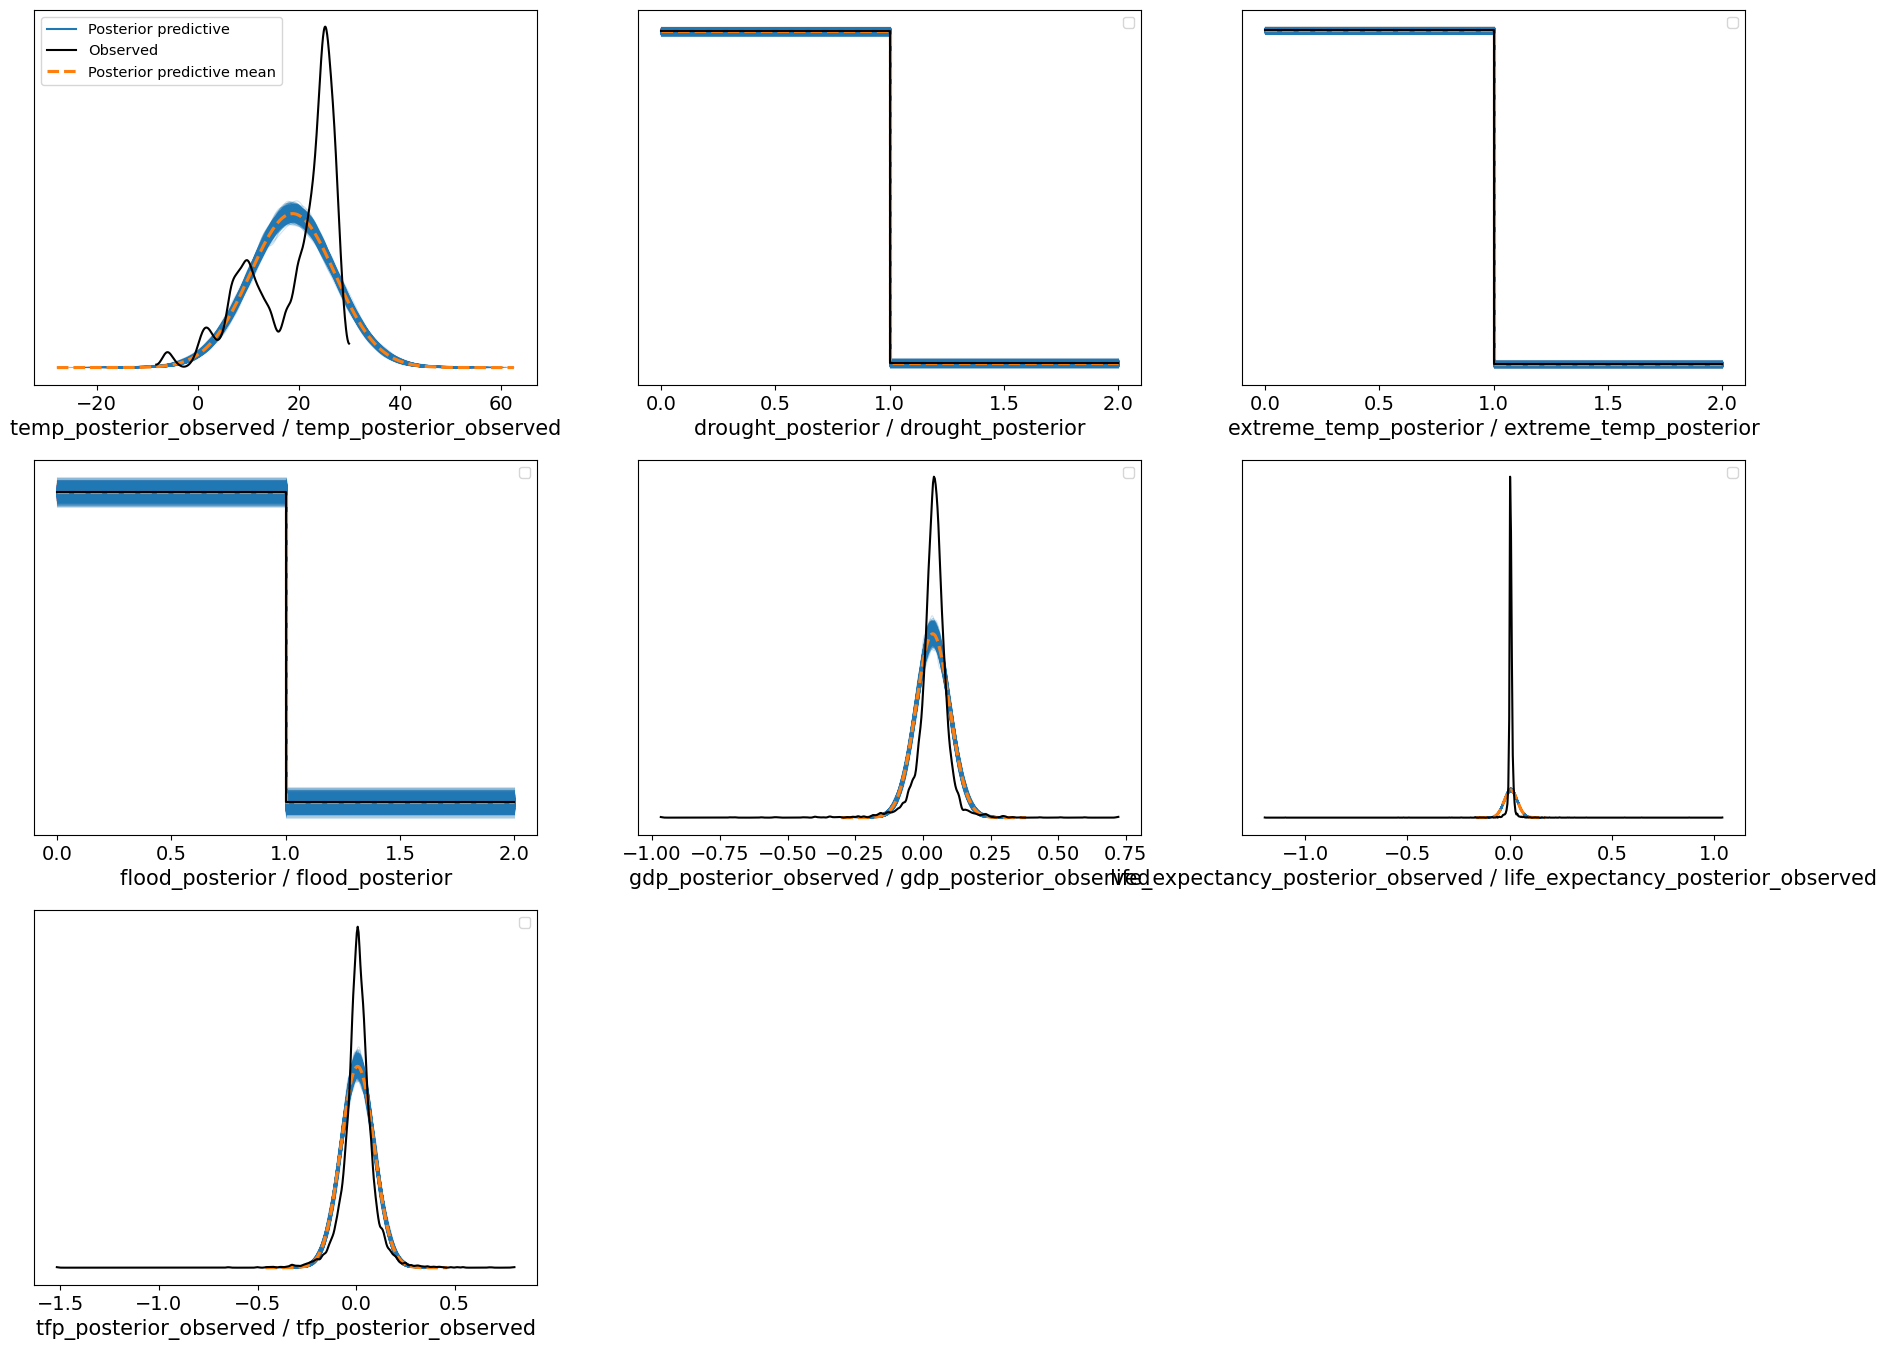

In [198]:
fig = az.plot_ppc(plot_posterior).ravel()[0].figure
fig.show()

In [200]:
low_temp_gdp = []
high_temp_gdp = []
mean = np.mean(posterior["temp_posterior"][0][0])
for i in range(len(integrated_data["Unweighted_Temp"])):
    if posterior["temp_posterior"][0][0][i].data < mean:
        low_temp_gdp.append(posterior["life_expectancy_posterior"][0][0][i].data)
    elif posterior["temp_posterior"][0][0][i].data > mean:
        high_temp_gdp.append(posterior["life_expectancy_posterior"][0][0][i].data)
print(np.mean(low_temp_gdp))
print(np.mean(high_temp_gdp))

0.004122715316336207
0.006415490788486963


In [208]:
no_flood_ag_output = []
flood_ag_output = []
for i in range(len(integrated_data["Unweighted_Temp"])):
    flood = plot_posterior["posterior_predictive"]["flood_posterior"][0][0][i].data
    if flood == 0:
        no_flood_ag_output.append(plot_posterior["posterior_predictive"]["tfp_posterior"][0][0][i].data)
    else:
        flood_ag_output.append(plot_posterior["posterior_predictive"]["tfp_posterior"][0][0][i].data)
print(np.mean(no_flood_ag_output))
print(np.mean(flood_ag_output))

0.005727807066887119
0.01393844229914175


/Users/hayden.freedman/miniconda3/envs/env_data_modeling/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/hayden.freedman/miniconda3/envs/env_data_modeling/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


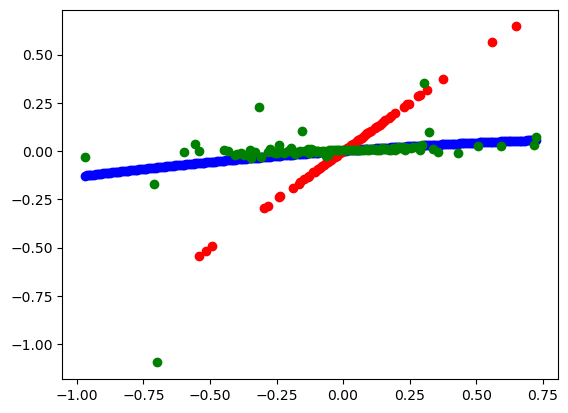

In [181]:
x_vals = []
regression_y_vals = []
sampled_y_vals = []
observed_y_vals = []
coef1_mean = np.mean(posterior["gdp_life_expectancy_coef"][0].data)
coef2_mean = np.mean(posterior["gdp_life_expectancy_coef2"][0].data)
intercept_mean = np.mean(posterior["life_expectancy_intercept"][0].data)

min_x_val = np.min(posterior["gdp_posterior"][0].data)
max_x_val = np.max(posterior["gdp_posterior"][0].data)

increment = abs(max_x_val - min_x_val) / 500

for x_val in np.linspace(
    min_x_val,
    max_x_val,
    num=250
):  
    x_vals.append(x_val)
    regression_y_vals.append((coef1_mean * x_val) + (coef2_mean * (x_val**2)) + intercept_mean)
    sampled_data = []
    for sample in range(len(integrated_data["ln_Life_Expectancy_change"])):
        sample_val = posterior["life_expectancy_posterior"][0].data[0][sample]
        if sample_val >= x_val-increment and sample_val <= x_val+increment:
            sampled_data.append(posterior["life_expectancy_posterior"][0].data[0][sample])
    sampled_y_vals.append(np.mean(sampled_data))
    observed_data = []
    for index, observed_val in enumerate(integrated_data["ln_GDP_Change"]):
        if observed_val >= x_val-increment and observed_val <= x_val+increment:
            if not np.isnan(integrated_data["ln_Life_Expectancy_change"][index]):
                observed_data.append(integrated_data["ln_Life_Expectancy_change"][index])
    observed_y_vals.append(np.mean(observed_data))

plt.scatter(x_vals, regression_y_vals, color="blue")
plt.scatter(x_vals, sampled_y_vals, color="red")
plt.scatter(x_vals, observed_y_vals, color="green")
plt.show()

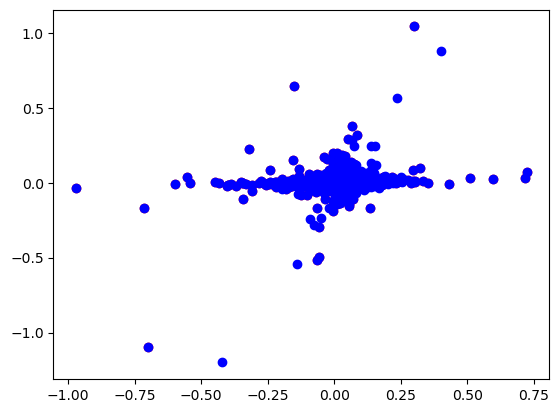

In [194]:
# get the distribution of life expectancy change and below 13C temp threshold
temp_samples = posterior["temp_posterior"][2].data[1]
gdp_samples = posterior["gdp_posterior"][2].data[1]
life_expectancy_samples = posterior["life_expectancy_posterior"][2].data[1]
temp_observed = integrated_data["Unweighted_Temp"]
gdp_observed = integrated_data["ln_GDP_Change"]
life_expectancy_observed = integrated_data["ln_Life_Expectancy_change"]
plt.scatter(gdp_observed, life_expectancy_observed, color="red")
plt.scatter(gdp_samples, life_expectancy_samples, color="blue")
plt.show()

# Create integrated dataset

In [59]:
integrated_data_dict = {
    "Country":[],
    "Year":[],
    "Unweighted_Temp":[],
    "Drought":[],
    "Extreme temperature":[],
    "Flood":[],
    "ln_GDP_Change":[],
    "ln_TFP_Change":[],
    "ln_Life_Expectancy_change":[]
}

unweighted_temp = pd.read_csv("../data/burke/data/input/custom_monthly_unweighted_temp_by_country.csv")
burke_data = pd.read_csv("../data/processed/burke_country_temp_gdp.csv")
ortizbobea_data = pd.read_csv("../data/processed/ortiz_bobea_country_temp_tfp_output.csv")
extreme_weather_data = pd.read_csv("../data/global_data/extreme_weather_events.csv")
life_expectancy_data = pd.read_csv("../data/global_data/life_expectancy_world_bank.csv")

all_countries = set(ortizbobea_data["Country"]).intersection(set(burke_data["Country"])).intersection(set(extreme_weather_data["ISO"])).intersection(set(life_expectancy_data["Country Code"]))
all_years = sorted(set(ortizbobea_data["Year"]) | set(burke_data["Year"]))
last_gdp = np.NaN
count = 0
for index, country in enumerate(list(all_countries)):
    last_life_expectancy = np.NaN
    last_gdp = np.NaN
    count += 1
    for year in all_years:
        burke_row = burke_data.loc[(burke_data["Country"] == country) & (burke_data["Year"] == year)]
        ob_row = ortizbobea_data.loc[(ortizbobea_data["Country"] == country) & (ortizbobea_data["Year"] == year)]
        ew_rows = extreme_weather_data.loc[(extreme_weather_data["DisNo."].str.startswith(str(year), na=False)) & (extreme_weather_data["ISO"] == country)]
        integrated_data_dict["Country"].append(country)
        integrated_data_dict["Year"].append(year)
        unweighted_temps = list(unweighted_temp.loc[(unweighted_temp["Country"] == country) & (unweighted_temp["Year"] == year)]["Mean_Temp"])
        integrated_data_dict["Unweighted_Temp"].append(np.nanmean(unweighted_temps))
        try:
            integrated_data_dict["ln_TFP_Change"].append(ob_row["ln_TFP_change"].item())
        except ValueError:
            integrated_data_dict["ln_TFP_Change"].append(np.NaN)
        try:
            curr_gdp = burke_row["GDP"].item()
        except ValueError:
            curr_gdp = np.NaN
        if np.isnan(last_gdp) or np.isnan(curr_gdp):
            integrated_data_dict["ln_GDP_Change"].append(np.NaN)
        else:
            integrated_data_dict["ln_GDP_Change"].append(np.log(curr_gdp)-np.log(last_gdp))
        last_gdp = curr_gdp
        for disaster_type in ["Flood","Drought","Extreme temperature"]:
            if len(ew_rows) == 0:
                integrated_data_dict[disaster_type].append(0)
            else:
                if any(ew_row["Disaster Type"] == disaster_type for _, ew_row in ew_rows.iterrows()):
                    integrated_data_dict[disaster_type].append(1)
                else:
                    integrated_data_dict[disaster_type].append(0)
        curr_life_expectancy = life_expectancy_data.loc[(life_expectancy_data["Country Code"] == country)][str(year)].item()
        if not np.isnan(last_life_expectancy) and not np.isnan(curr_life_expectancy):
            integrated_data_dict["ln_Life_Expectancy_change"].append(np.log(curr_life_expectancy) - np.log(last_life_expectancy))
        else:
            integrated_data_dict["ln_Life_Expectancy_change"].append(np.NaN)
        last_life_expectancy = curr_life_expectancy
pd.DataFrame.from_dict(integrated_data_dict).to_csv("../data/processed/five_node_model_integrated_data.csv")    

/var/folders/q3/myxq41dd4_9c_rx76zlk8f3r0000gn/T/ipykernel_5468/2281520744.py:34: RuntimeWarning: Mean of empty slice
  integrated_data_dict["Unweighted_Temp"].append(np.nanmean(unweighted_temps))
